# Model Development: Airline Delay
<img src="../assets/airline-pic.jpg" alt="Title-Pic">

# Imports

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from datetime import datetime
from pandas import Series, DataFrame
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score


np.set_printoptions(suppress=True)
sns.set(rc={"figure.figsize": (10, 6), "axes.titlesize": 20, "axes.titleweight": "bold", "axes.labelsize": 15})
warnings.filterwarnings('ignore')

# Data

In [2]:
def export_model(model, model_name):
    timestamp_string = str(datetime.now())[:19].replace(" ", "").replace(":", "").replace("-", "")
    export_path = f"../trained_models/{timestamp_string}_{model_name}"
    with open(export_path, "wb") as model_file:
        pickle.dump(model, model_file)
    
    return export_path

In [3]:
def load_model(model_path):
    with open(model_path, "rb") as model_file:
        return pickle.load(model_file)

In [16]:
def print_top_rankings(grid_model, top=10):
    sorted_zipped_report = sorted(
        zip(
            grid_model.cv_results_["params"], 
            grid_model.cv_results_["mean_test_score"], 
            grid_model.cv_results_["rank_test_score"]
        ), key=lambda item: item[2]
    )
    for (i, (params, score, rank)) in enumerate(sorted_zipped_report):
        if i >= top:
            break

        print(f"Rank: {rank}\tScore: {score}\nParam: {params}\n")

def print_model_classification_report(model, X_data, y_data):
    preds_test = model.predict(X_data)
    preds_train = model.predict(X_train)

    f1_score_test = f1_score(y_data, preds_test, average="macro")
    accuracy_score_test = accuracy_score(y_data, preds_test)
    f1_score_train = f1_score(y_train, preds_train, average="macro")
    accuracy_score_train = accuracy_score(y_train, preds_train)

    print(f"Accuracy-Score:\t{accuracy_score_test}\t|\tTrain-Accuracy-Score:\t{accuracy_score_train}")
    print(f"F1-Score:\t{f1_score_test}\t|\tTrain-F1-Score:\t\t{f1_score_train}\n")
    print(classification_report(y_data, preds_test))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_data, preds_test), annot=True, cmap="cool", fmt='.5g')

# def print_feature_importance(model):
#     return Series(data=model.feature_importances_, index=DATA_COLUMN_NAMES).sort_values(ascending=False)

In [17]:
MODEL_DATA = np.load("../model_data/nasa_prep_data.npz", allow_pickle=True)
inputs = MODEL_DATA["inputs"]
targets = MODEL_DATA["targets"]

X_train, X_tmp_test, y_train, y_tmp_test = train_test_split(inputs, targets, test_size=0.2, random_state=101)
X_test, X_val, y_test, y_val = train_test_split(X_tmp_test, y_tmp_test, test_size=0.5, random_state=101)

(X_train.shape, X_test.shape, X_val.shape), (y_train.shape, y_test.shape, y_val.shape)

(((478590, 613), (59824, 613), (59824, 613)), ((478590,), (59824,), (59824,)))

# Build the Model

## Model1: Gradient Boosting

Recall-Score:	0.6559240438619952	|	Train-Accuracy:	0.665360747194885
F1-Score:	0.6552207109124562	|	Train-F1-Score:	0.6646010728274905

              precision    recall  f1-score   support

           0       0.64      0.70      0.67     29781
           1       0.67      0.61      0.64     30043

    accuracy                           0.66     59824
   macro avg       0.66      0.66      0.66     59824
weighted avg       0.66      0.66      0.66     59824



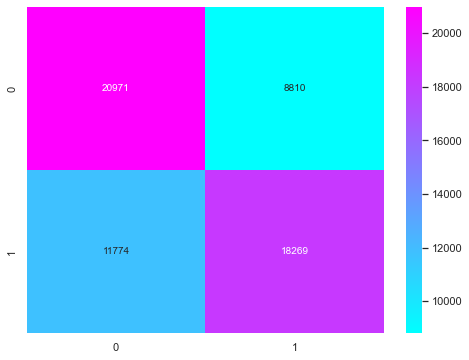

In [19]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
print_model_classification_report(xgb_model, X_test, y_test)

In [12]:
xgb_tmp_model = XGBClassifier()

xgb_grid_params = {
    "eval_metric": ["logloss"],
    "n_estimators": [700, 900],
    "learning_rate": [0.01],
    "min_child_weight": [3, 8],
    "eta": [0.05],
    "gamma": [6],
    "subsample": [0.5, 0.7],
    "max_depth": [4, 10],
    "colsample_bytree": [0.5]
}

xgb_grid_model = GridSearchCV(xgb_tmp_model, xgb_grid_params, cv=2, verbose=3, scoring="f1_macro")

xgb_grid_model.fit(X_train, y_train);

In [24]:
xgb_grid_model.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
print_model_classification_report(xgb_grid_model.best_estimator_, X_test, y_test)

In [53]:
print_top_rankings(xgb_grid_model, top=10)

Rank: 1	Score: 0.6525021417079337
Param: {'colsample_bytree': 0.5, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 6, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 900, 'subsample': 0.5}



## Model2: RandomForest

Recall-Score:	0.6339596148702862	|	Train-Accuracy:	0.8362188929981822
F1-Score:	0.6338789471583962	|	Train-F1-Score:	0.8362142723818695

              precision    recall  f1-score   support

           0       0.63      0.65      0.64     29781
           1       0.64      0.62      0.63     30043

    accuracy                           0.63     59824
   macro avg       0.63      0.63      0.63     59824
weighted avg       0.63      0.63      0.63     59824



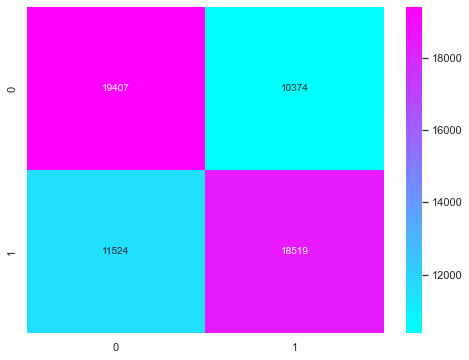

In [23]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
print_model_classification_report(rf_model, X_test, y_test)

In [10]:
rf_tmp_model = RandomForestClassifier()

rf_grid_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": [50, 90, 150],
    "min_samples_split": [3, 7],
    "min_samples_leaf": [3, 7],
    "n_estimators": [500, 700],
    "max_samples": [0.9],
    "bootstrap": [True]
}

rf_grid_model = GridSearchCV(rf_tmp_model, rf_grid_params, cv=2, scoring="f1_macro", verbose=3)

rf_grid_model.fit(X_train, y_train);

In [ ]:
xgb_grid_model.best_params_

{'C': 7, 'coef0': 1, 'degree': 8, 'gamma': 'auto', 'kernel': 'poly'}

In [12]:
print_model_classification_report(xgb_grid_model.best_estimator_, X_test, y_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [ ]:
print_top_rankings(xgb_grid_model.best_estimator_, top=10)

# Final Model Selection

## Model Validation

## Model Selection